In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


def show_frame(frame):
    plt.imshow(frame, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def show_contour(frame, contour):
    vis = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    # 绘制外轮廓（绿色线）
    cv2.drawContours(vis, [contour], -1, (0, 255, 0), 2)

    # 显示图像
    plt.figure(figsize=(8, 8))
    plt.imshow(vis)
    plt.title("Contour on Original Frame")
    plt.axis("off")
    plt.show()

In [2]:
pixel_spacing = 0.084

In [ ]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output

# 读取 TIFF 图像堆栈
stack = tifffile.imread("data/020151.tiff")
total_frames = stack.shape[0]

# CLAHE 增强器
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# 创建滑块
frame_slider = widgets.IntSlider(value=0, min=0, max=total_frames - 1, step=1, description='Frame:')

# 创建按钮
prev_button = widgets.Button(description='◀ Previous')
next_button = widgets.Button(description='Next ▶')

# 显示区域
output = widgets.Output()

# 图像显示函数
def update_display(change=None):
    frame_index = frame_slider.value
    frame = stack[frame_index]
    enhanced = clahe.apply(frame)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    with output:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        # 原图
        plt.subplot(1, 2, 1)
        plt.imshow(frame, cmap='gray')
        plt.title(f"Original Frame {frame_index}")
        plt.axis('off')

        # 二值图
        plt.subplot(1, 2, 2)
        plt.imshow(binary, cmap='gray')
        plt.title("Binary (CLAHE + Otsu)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 滑块更新绑定显示函数
frame_slider.observe(update_display, names='value')

# 按钮功能
def on_prev_clicked(b):
    if frame_slider.value > 0:
        frame_slider.value -= 1

def on_next_clicked(b):
    if frame_slider.value < total_frames - 1:
        frame_slider.value += 1

prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

# 布局
controls = widgets.HBox([prev_button, frame_slider, next_button])
display(controls, output)

# 初始显示
update_display()

Output()

In [5]:
import cv2
import numpy as np
import tifffile

stack = tifffile.imread("data/020150.tiff")
frame = stack[1647]

# CLAHE增强
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(frame)

# 二值化
_, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 确保是单通道
if len(binary.shape) == 3:
    binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
# 确保是uint8类型
binary = binary.astype(np.uint8)

# show_frame(binary)

In [6]:
def is_contour_circular(cnt, circularity_thresh=0.6, axis_ratio_thresh=0.6):
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    if perimeter == 0:
        return False

    circularity = 4 * np.pi * area / (perimeter ** 2)
    is_round = circularity > circularity_thresh

    if len(cnt) >= 5:
        _, axes, _ = cv2.fitEllipse(cnt)
        axis_ratio = min(axes) / max(axes)
        is_round = is_round and (axis_ratio > axis_ratio_thresh)

    return is_round

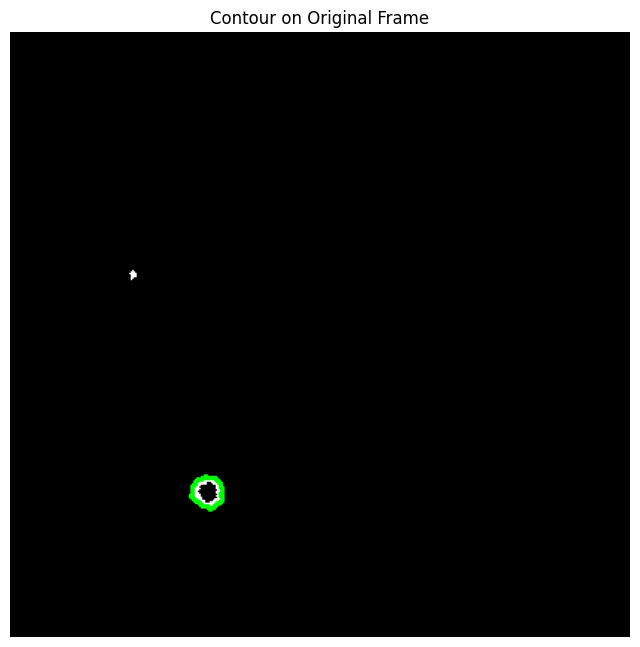

outer radius: 0.85 mm, outer area: 2.29 mm²
is a circle: True


In [18]:
# binary 是你二值化后的图像
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]  # 形状为 (N, 4)

# 1. 找最大外轮廓（父轮廓为 -1，面积最大）
outer_idx = -1
outer_area = 0
for i, cnt in enumerate(contours):
    if hierarchy[i][3] == -1:
        area = cv2.contourArea(cnt)
        if area > outer_area:
            outer_area = area
            outer_idx = i

outer = contours[outer_idx]

outer_area = cv2.contourArea(outer)
outer_radius = np.sqrt(outer_area / np.pi)
show_contour(binary, outer)
print(f"outer radius: {outer_radius * pixel_spacing:.2f} mm, outer area: {outer_area * (pixel_spacing ** 2):.2f} mm²")
print(f"is a circle: {is_contour_circular(outer)}")

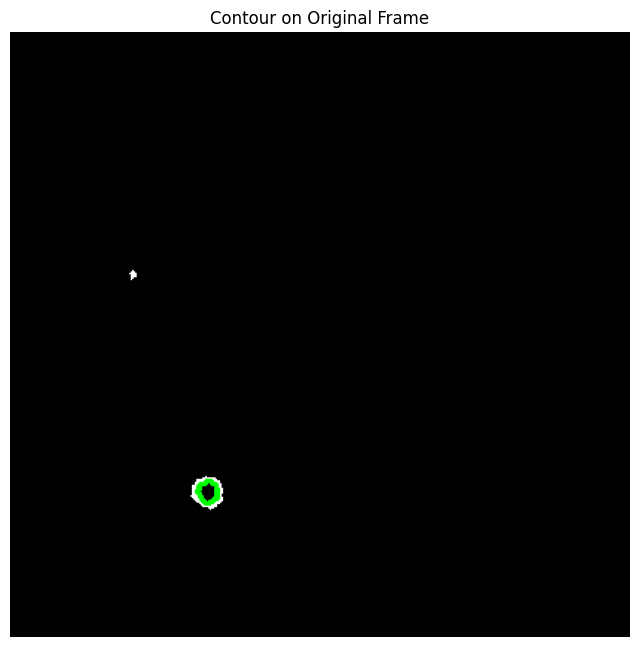

inner radius: 0.56mm, inner area:0.98mm^2
wall thickness: 0.29mm
is a circle: True


In [19]:
# 2. 找这个外轮廓的最大子轮廓（即内壁）
inner_idx = hierarchy[outer_idx][2]  # 第一个子 contour
best_inner_idx = -1
max_inner_area = 0

while inner_idx != -1:
    area = cv2.contourArea(contours[inner_idx])
    if area > max_inner_area:
        max_inner_area = area
        best_inner_idx = inner_idx
    inner_idx = hierarchy[inner_idx][0]  # 兄弟轮廓

inner = contours[best_inner_idx]

inner_area = cv2.contourArea(inner)
inner_radius = np.sqrt(inner_area / np.pi)
show_contour(binary, inner)

print(f"inner radius: {inner_radius * pixel_spacing:.2f}mm, inner area:{inner_area * pixel_spacing ** 2:.2f}mm^2")
print(f"wall thickness: {(outer_radius - inner_radius) * pixel_spacing:.2f}mm")
print(f"is a circle: {is_contour_circular(inner)}")

In [9]:
def calculate_thickness(frame):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)

    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if len(binary.shape) == 3:
        binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    binary = binary.astype(np.uint8)

    # binary 是你二值化后的图像
    contours, hierarchy = cv2.findContours(
        binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    hierarchy = hierarchy[0]  # 形状为 (N, 4)

    # 1. 找最大外轮廓（父轮廓为 -1，面积最大）
    outer_idx = -1
    outer_area = 0
    for i, cnt in enumerate(contours):
        if hierarchy[i][3] == -1:
            area = cv2.contourArea(cnt)
            if area > outer_area:
                outer_area = area
                outer_idx = i

    # 没找到外轮廓就返回
    if outer_idx == -1 or not is_contour_circular(contours[outer_idx]):
        return None

    outer = contours[outer_idx]

    outer_area = cv2.contourArea(outer)
    outer_radius = np.sqrt(outer_area / np.pi)

    # 2. 找这个外轮廓的最大子轮廓（即内壁）
    inner_idx = hierarchy[outer_idx][2]  # 第一个子 contour
    best_inner_idx = -1
    max_inner_area = 0

    while inner_idx != -1:
        area = cv2.contourArea(contours[inner_idx])
        if area > max_inner_area:
            max_inner_area = area
            best_inner_idx = inner_idx
        inner_idx = hierarchy[inner_idx][0]  # 兄弟轮廓

    # 没找到内轮廓就返回
    if best_inner_idx == -1 or not is_contour_circular(contours[best_inner_idx]):
        return None

    inner = contours[best_inner_idx]

    inner_area = cv2.contourArea(inner)
    if inner_area < outer_area / 4:
        return None

    inner_radius = np.sqrt(inner_area / np.pi)

    return outer_radius - inner_radius

In [10]:
import pandas as pd

stack = tifffile.imread("data/020150.tiff")
total_frames = stack.shape[0]

thickness_list = []
frame_indices = []

# 遍历所有帧，计算厚度
for i in range(0, total_frames):
    frame = stack[i]
    thickness = calculate_thickness(frame)
    if thickness is not None:
        thickness *= pixel_spacing
        thickness_list.append(thickness)
        frame_indices.append(i)

# 创建 DataFrame
df = pd.DataFrame({"frame": frame_indices, "thickness": thickness_list})
average_thickness = df["thickness"].mean()
print(f"平均壁厚: {average_thickness:.4f} mm")

平均壁厚: 0.2602 mm


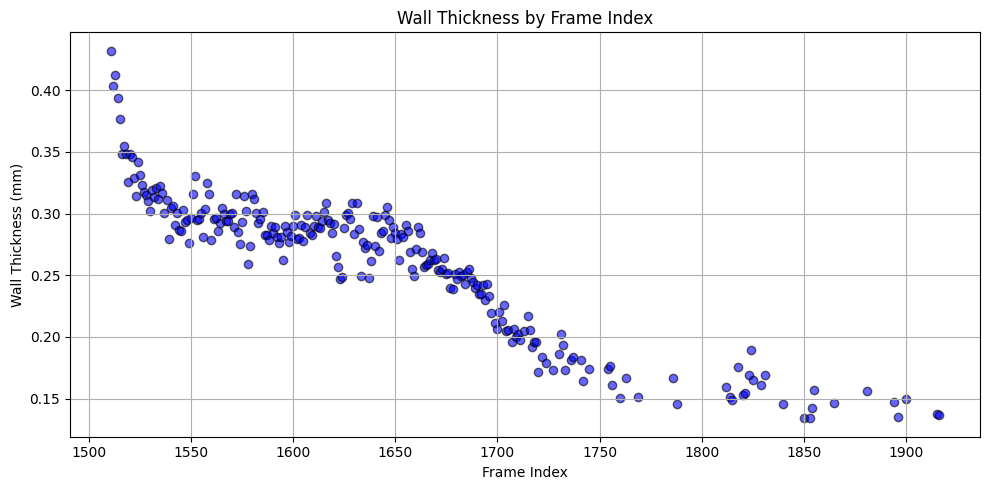

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(df["frame"], df["thickness"], c='blue', alpha=0.6, edgecolors='k')

plt.title("Wall Thickness by Frame Index")
plt.xlabel("Frame Index")
plt.ylabel("Wall Thickness (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
valid_frames = set(frame_indices)

print(f"有效帧数量: {len(valid_frames)}")

有效帧数量: 249
有效帧列表: [1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 167

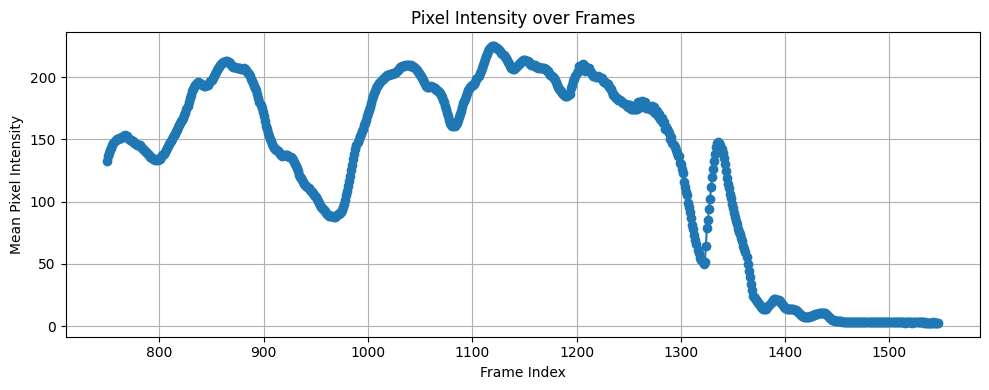

In [11]:
start_frame = 750
end_frame = 1547

intensity_list = []
for i in range(start_frame, end_frame + 1):
    frame = stack[i]
    mean_intensity = np.mean(frame)
    intensity_list.append(mean_intensity)
    
frame_numbers = list(range(start_frame, end_frame + 1))

# 绘图
plt.figure(figsize=(10, 4))
plt.plot(frame_numbers, intensity_list, marker='o', linestyle='-')
plt.title("Pixel Intensity over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Mean Pixel Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()